In [189]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import rc


In [190]:

ft = 10
fs = 12
fm = 18
fb = 22
fl = 26
#plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Times New Roman']
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
matplotlib.rc('font',**{'family':'serif','serif':['Times']})
matplotlib.rc('text', usetex=True)

In [191]:
# Define the equation of state using pow function
def eos_pow(J, gamma, bulk_modulus):
    return bulk_modulus / gamma * (J**(-gamma) - 1.0)
    # return bulk_modulus / gamma * (pow(J,-gamma) - 1.0)

def eos_powm1(sJ, gamma, bulk_modulus):
    return bulk_modulus / gamma * (pow((1.0-sJ),-gamma) - 1.0)

# Define the equation of state using log1p, expm1, and 1-J
def eos_bonus(sJ, gamma, bulk_modulus):
    return (bulk_modulus / gamma) * (np.expm1(-gamma * np.log1p(-sJ)))


# Define the equation of state using taylor expansion
def eos_taylor(J, gamma, bulk_modulus):
    return bulk_modulus / gamma * (-gamma * np.log(J) + 0.5 * gamma * gamma * np.log(J) * np.log(J) - 1.0)


In [192]:
rho = 1000.0 # Density kg/m^3
bulk_modulus = 2.2e9 # Bulk modulus Pa
gamma = 7.15 # Gruneisen parameter
nPoints = 100000 # Number of points to plot


low  = 0.9999999
high = 1.0000001
diff = 0.0000001

In [193]:
def compare_models(bulk_modulus, gamma, diff, low, high, nPoints, fn='compare_models.png'):
    # Plot the pressure as a function of depth for the different material model formulations. 
    # Given:
    # bulk_modulus: Bulk modulus (Pascals) K_0, imcompressibility of the material initially
    # gamma: Gruneisen parameter (unitless), sometimes called derivative of bulk modulus with respect to pressure (dK/dP) K'_0
    # diff: +/- from 1.0 for J (determinant of deformation gradient, i.e. volume change ratio)
    # low: lower bound for J
    # high: upper bound for J
    # nPoints: number of points to plot
    # Returns:
    # Plot of pressure vs. J for the different models
    
    # Create an array of J values
    J_array_32 = np.linspace(low, high, nPoints, dtype=np.float32) 
    J_array_64 = np.linspace(low, high, nPoints, dtype=np.float64) 
    sJ_array_32 = np.linspace(diff, -diff, nPoints, dtype=np.float32) 
    sJ_array_64 = np.linspace(diff, -diff, nPoints, dtype=np.float64) 
    sJ_array_128 = np.linspace(diff, -diff, nPoints, dtype=np.float128) 
    J_array_x = np.linspace(-diff, diff, nPoints, dtype=np.float128)



    # Compute the pressure using the equation of state
    pressure_pow_32 = eos_pow(J_array_32, gamma, bulk_modulus)
    pressure_powm1_32 = eos_powm1(sJ_array_32, gamma, bulk_modulus)
    pressure_log_32 = eos_bonus(sJ_array_32, gamma, bulk_modulus)

    pressure_pow_64 = eos_pow(J_array_64, gamma, bulk_modulus)
    pressure_powm1_64 = eos_powm1(sJ_array_64, gamma, bulk_modulus)
    pressure_log_64 = eos_bonus(sJ_array_64, gamma, bulk_modulus)
    pressure_log_128 = eos_bonus(sJ_array_128, gamma, bulk_modulus)
    #pressure_taylor = eos_taylor(J_array, gamma, bulk_modulus)

    fig, axes = plt.subplots(2, 1, figsize=(8, 6))

    # Format grid and ticks
    for ax in axes:
        ax.grid()
        ax.grid(which="major", axis="both", linewidth=0.75, color="grey", linestyle='--')
        ax.grid(which="minor", axis="both", linewidth=0.5, color="lightgrey", linestyle=':')
        ax.tick_params(top=True, right=True)
        ax.tick_params(which="both",direction="in", labelsize=fs, width=2, length=5)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)


    axes[0].set_xlim(-diff, diff)
    axes[1].set_xlim(-diff, diff)
    axes[1].set_xlabel('Relative Deformation (1 - J)', fontsize=fm)
    #axes.set_xscale('symlog')
    #plt.yscale('symlog')
    axes[0].set_ylabel('Pressure (Pa)', fontsize=fm)
    axes[1].set_ylabel('Percent Error (128 Bit)', fontsize=fm)


    # Plot the pressure as a function of depth
    axes[0].plot(J_array_x, pressure_log_64, label='Improved 128 Bit', color='black')
    axes[0].plot(J_array_x, pressure_pow_64, label='Standard 64 Bit')
    axes[0].plot(J_array_x, pressure_powm1_64, label='Modified 64 Bit')
    axes[0].plot(J_array_x, pressure_log_64, label='Improved 64 Bit')
    axes[0].plot(J_array_x, pressure_pow_32, label='Standard 32 Bit', linestyle='--')
    axes[0].plot(J_array_x, pressure_powm1_32, label='Modified 32 Bit', linestyle=':', color='blue')
    axes[0].plot(J_array_x, pressure_log_32, label='Improved 32 Bit', linestyle='--')

    # Plot the pressure as a function of depth
    axes[1].plot(J_array_x, (pressure_log_64 - pressure_log_128) / pressure_log_128 * 100.0, label='Improved 128 Bit', color='black')
    axes[1].plot(J_array_x, (pressure_pow_64- pressure_log_128) / pressure_log_128 * 100.0, label='Standard 64 Bit')
    axes[1].plot(J_array_x, (pressure_powm1_64- pressure_log_128) / pressure_log_128 * 100.0, label='Modified 64 Bit')
    axes[1].plot(J_array_x, (pressure_log_64- pressure_log_128) / pressure_log_128 * 100.0, label='Improved 64 Bit')
    axes[1].plot(J_array_x, (pressure_pow_32- pressure_log_128) / pressure_log_128 * 100.0, label='Standard 32 Bit', linestyle='--')
    axes[1].plot(J_array_x, (pressure_powm1_32- pressure_log_128) / pressure_log_128 * 100.0, label='Modified 32 Bit', linestyle=':', color='blue')
    axes[1].plot(J_array_x, (pressure_log_32- pressure_log_128) / pressure_log_128 * 100.0, label='Improved 32 Bit', linestyle='--')


    #plt.plot(J_array, pressure_taylor, label='taylor')

    axes[0].legend()

    plt.savefig(fn, dpi=300, bbox_inches='tight')

    plt.show()


/home/JustinBonus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/JustinBonus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/JustinBonus/.local/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


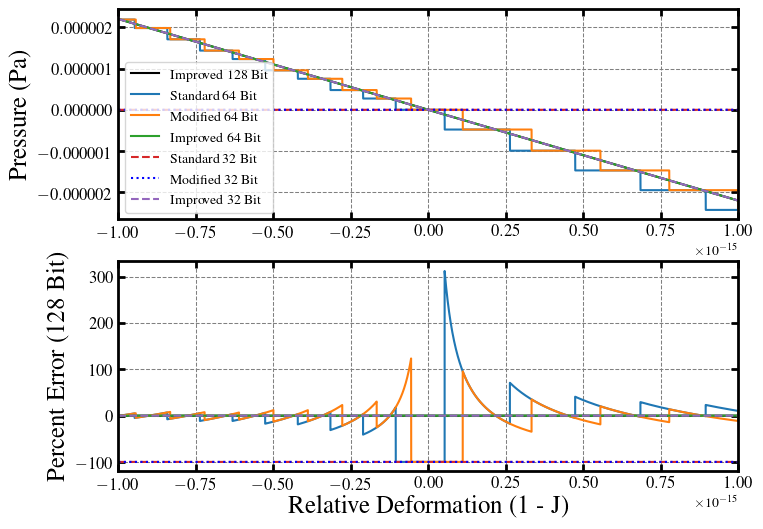

In [194]:
low  = 0.999999999999999
high = 1.000000000000001
diff = 0.000000000000001
compare_models(bulk_modulus, gamma, diff, low, high, nPoints, fn="jfluid_compare_double_08062023.png")


/home/JustinBonus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/JustinBonus/.local/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


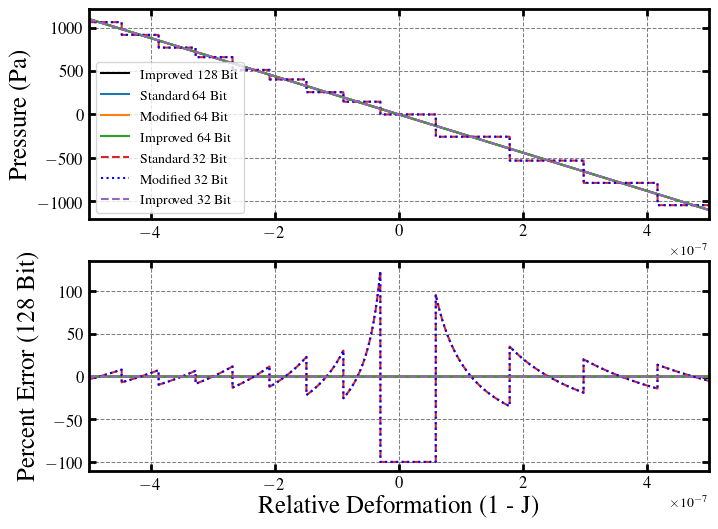

In [195]:


low  = 0.9999995
high = 1.0000005
diff = 0.0000005

compare_models(bulk_modulus, gamma, diff, low, high, nPoints, fn="jfluid_compare_single_08062023.png")

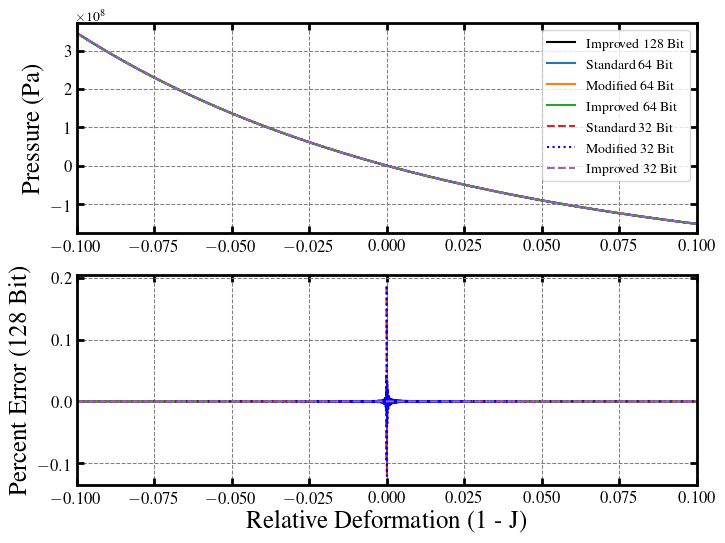

In [201]:

low  = 0.9
high = 1.1
diff = 0.1

compare_models(bulk_modulus, gamma, diff, low, high, nPoints, fn="jfluid_compare_zero_08062023.png")

In [ ]:


# low  = 0.999999999999999999999999999999999
# high = 1.000000000000000000000000000000001
# diff = 0.000000000000000000000000000000001
low  = 0.9999999
high = 1.0000001
diff = 0.0000001
J_array_32 = np.linspace(low, high, nPoints, dtype=np.float32) 
J_array_64 = np.linspace(low, high, nPoints, dtype=np.float64) 
sJ_array_32 = np.linspace(diff, -diff, nPoints, dtype=np.float32) 
sJ_array_64 = np.linspace(diff, -diff, nPoints, dtype=np.float64) 
J_array_x = np.linspace(0.99999, 1.00001, nPoints, dtype=np.float64)
rho = 1000.0 # Density kg/m^3
bulk_modulus = 2.2e9 # Bulk modulus Pa
gamma = 7.15 # Gruneisen parameter

# Compute the pressure using the equation of state
pressure_pow_32 = eos_pow(J_array_32, gamma, bulk_modulus)
pressure_powm1_32 = eos_powm1(sJ_array_32, gamma, bulk_modulus)
pressure_log_32 = eos_bonus(sJ_array_32, gamma, bulk_modulus)

pressure_pow_64 = eos_pow(J_array_64, gamma, bulk_modulus)
pressure_powm1_64 = eos_powm1(sJ_array_64, gamma, bulk_modulus)
pressure_log_64 = eos_bonus(sJ_array_64, gamma, bulk_modulus)

#pressure_taylor = eos_taylor(J_array, gamma, bulk_modulus)

# Plot the pressure as a function of depth
plt.plot(J_array_x, pressure_pow_64, label='Standard 64 Bit')
plt.plot(J_array_x, pressure_powm1_64, label='Modified 64 Bit')
plt.plot(J_array_x, pressure_log_64, label='Improved 64 Bit')
plt.plot(J_array_x, pressure_pow_32, label='Standard 32 Bit', linestyle='--')
plt.plot(J_array_x, pressure_powm1_32, label='Modified 32 Bit', linestyle='--')
plt.plot(J_array_x, pressure_log_32, label='Improved 32 Bit', linestyle='--')

#plt.plot(J_array, pressure_taylor, label='taylor')
plt.xlabel('J')
plt.ylabel('Pressure (Pa)')
plt.legend()
plt.xscale('log')
#plt.yscale('symlog')
plt.show()

#print((sJ_array))
print(pressure_pow_32)
print(pressure_log_32)

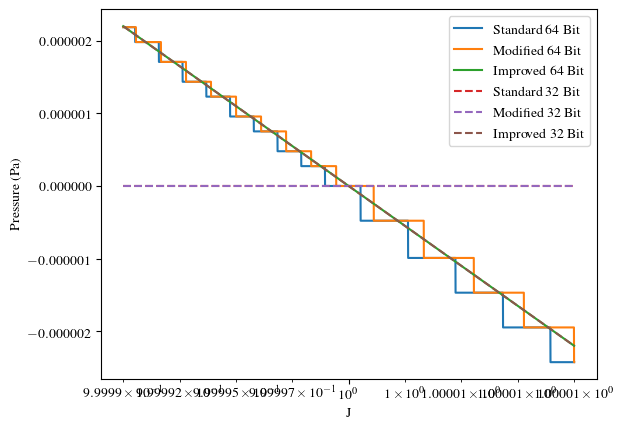

[0. 0. 0. ... 0. 0. 0.]
[ 2.2000002e-06  2.1995602e-06  2.1991202e-06 ... -2.1991202e-06
 -2.1995602e-06 -2.2000002e-06]


In [197]:

nPoints = 10000
# low  = 0.999999999999999999999999999999999
# high = 1.000000000000000000000000000000001
# diff = 0.000000000000000000000000000000001
low  = 0.999999999999999
high = 1.000000000000001
diff = 0.000000000000001
J_array_32 = np.linspace(low, high, nPoints, dtype=np.float32) 
J_array_64 = np.linspace(low, high, nPoints, dtype=np.float64) 
sJ_array_32 = np.linspace(diff, -diff, nPoints, dtype=np.float32) 
sJ_array_64 = np.linspace(diff, -diff, nPoints, dtype=np.float64) 
J_array_x = np.linspace(0.99999, 1.00001, nPoints, dtype=np.float64)
rho = 1000.0 # Density kg/m^3
bulk_modulus = 2.2e9 # Bulk modulus Pa
gamma = 7.15 # Gruneisen parameter

# Compute the pressure using the equation of state
pressure_pow_32 = eos_pow(J_array_32, gamma, bulk_modulus)
pressure_powm1_32 = eos_powm1(sJ_array_32, gamma, bulk_modulus)
pressure_log_32 = eos_bonus(sJ_array_32, gamma, bulk_modulus)

pressure_pow_64 = eos_pow(J_array_64, gamma, bulk_modulus)
pressure_powm1_64 = eos_powm1(sJ_array_64, gamma, bulk_modulus)
pressure_log_64 = eos_bonus(sJ_array_64, gamma, bulk_modulus)

#pressure_taylor = eos_taylor(J_array, gamma, bulk_modulus)

# Plot the pressure as a function of depth
plt.plot(J_array_x, pressure_pow_64, label='Standard 64 Bit')
plt.plot(J_array_x, pressure_powm1_64, label='Modified 64 Bit')
plt.plot(J_array_x, pressure_log_64, label='Improved 64 Bit')
plt.plot(J_array_x, pressure_pow_32, label='Standard 32 Bit', linestyle='--')
plt.plot(J_array_x, pressure_powm1_32, label='Modified 32 Bit', linestyle='--')
plt.plot(J_array_x, pressure_log_32, label='Improved 32 Bit', linestyle='--')

#plt.plot(J_array, pressure_taylor, label='taylor')
plt.xlabel('J')
plt.ylabel('Pressure (Pa)')
plt.legend()
plt.xscale('log')
#plt.yscale('symlog')
plt.show()

#print((sJ_array))
print(pressure_pow_32)
print(pressure_log_32)